![](https://assets.website-files.com/60e7f71b22c6d0b9cf329ceb/621e1a2f28ded71ee95aeede_6ProvenSalesForecastingMethodstoDriveRevenue1_a117440b5ae227c3dba5264a6521da06_2000.png)

# Introdução

O objetivo deste projeto é desenvolver um modelo de regressão para prever a demanda dos próximos 5 dias do item da empresa **Frexco**, baseado nas datas e seus respectivos números de vendas. Para desenvolver esse modelo serão utilizadas técnicas de machine learning e serão testados os desempenhos de diferentes algoritmos de regressão.

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('Dados.xlsx', index_col=0)

In [3]:
df = df.reset_index(level=0)

In [4]:
df.head()

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


In [5]:
df['Data'] = df['Data'].astype(str)

In [6]:
df[['Ano', 'Mes', 'Dia']] = df['Data'].str.split('-', expand=True).astype(int)
df.head()

,Data,Vendas,Ano,Mes,Dia
0,2022-12-06,870,2022,12,6
1,2022-12-07,868,2022,12,7
2,2022-12-08,1189,2022,12,8
3,2022-12-09,742,2022,12,9
4,2022-12-10,317,2022,12,10


# Análise Exploratória de Dados (EDA)

In [7]:
import seaborn as sns
import plotly.express as px

In [8]:
import plotly.io as pio
pio.renderers.default = "svg"

In [9]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


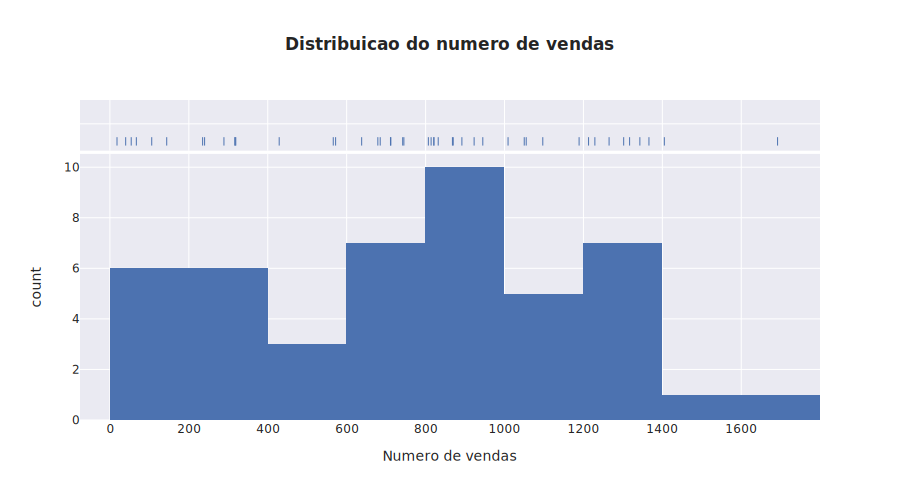

In [10]:
px.histogram(df,x='Vendas', width=900, marginal='rug',template='seaborn',labels={'Vendas':'Numero de vendas'},title="<b> Distribuicao do numero de vendas")

A maior frequência de número de vendas está no intervalo de 800 a 1000 vendas.

In [11]:
vendas = np.array(df['Vendas'])

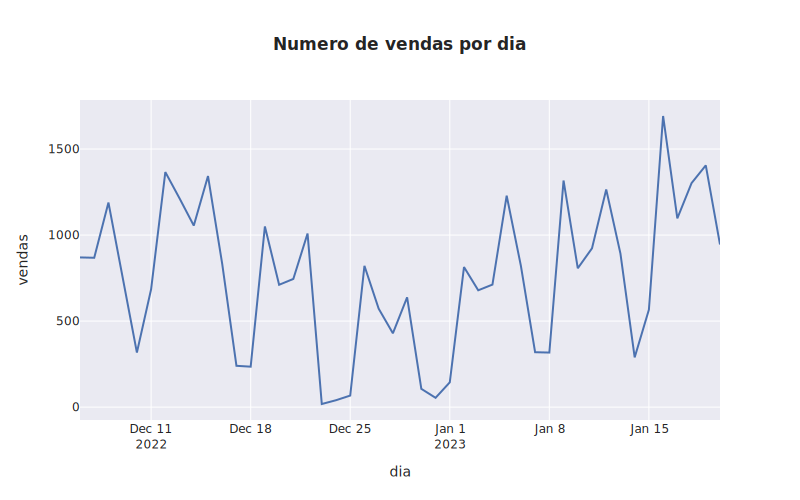

In [12]:
fig = px.line(df, x="Data", y="Vendas", width=800, labels={'Data':'dia','Vendas':'vendas'}, template="seaborn",title="<b> Numero de vendas por dia")
fig.show()

In [13]:
z = df.sort_values('Vendas', ascending=False).reset_index(drop=True)

In [14]:
z = z[['Data', 'Vendas']]

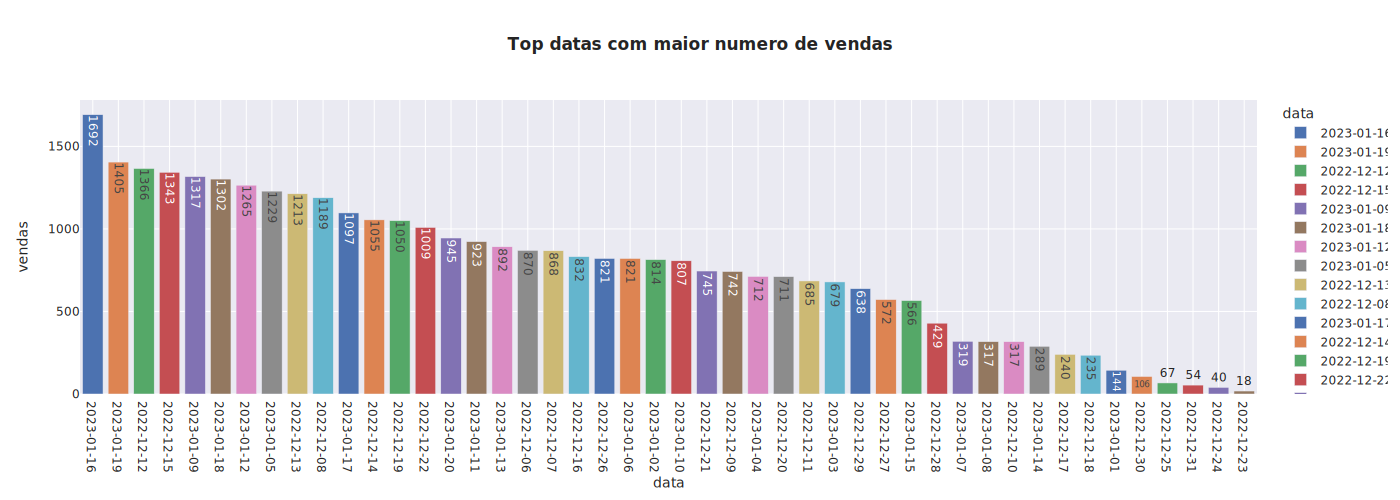

In [15]:
fig=px.bar(z,x='Data',y='Vendas',color='Data', width=1400,
           labels={'Data':'data','Vendas':'vendas'},text='Vendas',template='seaborn',title="<b> Top datas com maior numero de vendas")

fig.update_layout(
xaxis_type = 'category'
)

fig.show()

In [16]:
z = df[df['Dia'] <= 20]
z = df.groupby('Mes', as_index=False)[['Vendas']].sum().sort_values(by='Vendas',ascending=False)
z = z.replace(1, 'Janeiro de 2023')
z = z.replace(12, 'Dezembro de 2022')

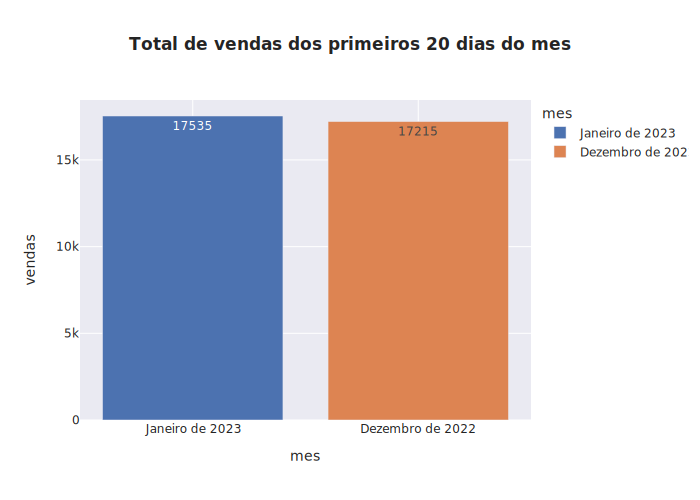

In [17]:
fig=px.bar(z,x='Mes',y='Vendas',color='Mes',
           labels={'Mes':'mes','Vendas':'vendas'},text='Vendas',template='seaborn',title="<b> Total de vendas dos primeiros 20 dias do mes")

fig.show()

# Machine Learning

## Análise das features

Como queremos calcular a correlação entre features categóricas e numéricas, será utilizada a medida de **correlation ratio (eta)**.

In [18]:
def correlation_ratio(categories, values):
    categories = np.array(categories)
    values = np.array(values)
    
    ssw = 0
    ssb = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ssw += sum((subgroup-np.mean(subgroup))**2)
        ssb += len(subgroup)*(np.mean(subgroup)-np.mean(values))**2
        
    Eta = (ssb / (ssb + ssw))**.5

    return Eta

In [19]:
Dia_coef = correlation_ratio(df['Dia'], df['Vendas'])
Mes_coef = correlation_ratio(df['Mes'], df['Vendas'])
Ano_coef = correlation_ratio(df['Ano'], df['Vendas'])

features_corr = {
                 'Dia':Dia_coef
                ,'Mês':Mes_coef
                ,'Ano':Ano_coef
                 }

In [20]:
features_corr = sorted(features_corr.items(), key=lambda x: x[1], reverse=True)

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

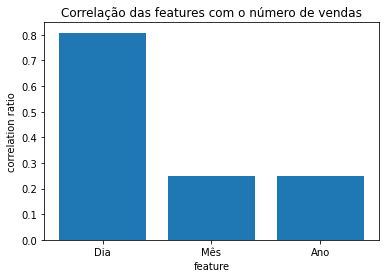

In [22]:
names = list(zip(*features_corr))[0]
values = list(zip(*features_corr))[1]

plt.bar(range(len(features_corr)), values, tick_label=names)
plt.title('Correlação das features com o número de vendas')
plt.xlabel('feature')
plt.ylabel('correlation ratio')
plt.show()

A variável mais relacionada com o número de vendas é o **dia**. O **mês** e **ano** possuem menos importância, mas **não** uma importância insignificativa.

## Data Visualization

In [23]:
import warnings
warnings.filterwarnings("ignore")

# registrando o número de vendas dos próximos 5 dias para cada amostra
df["Vendas_1"] = np.nan
df["Vendas_2"] = np.nan
df["Vendas_3"] = np.nan
df["Vendas_4"] = np.nan
df["Vendas_5"] = np.nan

for i in range(len(df['Vendas'])-6):
  df['Vendas_1'][i] = df['Vendas'][i+1]
  df['Vendas_2'][i] = df['Vendas'][i+2]
  df['Vendas_3'][i] = df['Vendas'][i+3]
  df['Vendas_4'][i] = df['Vendas'][i+4]
  df['Vendas_5'][i] = df['Vendas'][i+5]

df = df.dropna()

In [24]:
data = df.drop(['Data'], axis=1)
data[['Ano', 'Mes', 'Dia']] = data[['Ano', 'Mes', 'Dia']].astype(str)

# one hot encoding variáveis categóricas
data = pd.get_dummies(data)

In [25]:
data.head()

,Vendas,Vendas_1,Vendas_2,Vendas_3,Vendas_4,Vendas_5,Ano_2022,Ano_2023,Mes_1,Mes_12,...,Dia_29,Dia_3,Dia_30,Dia_31,Dia_4,Dia_5,Dia_6,Dia_7,Dia_8,Dia_9
0,870,868.0,1189.0,742.0,317.0,685.0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,868,1189.0,742.0,317.0,685.0,1366.0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,1189,742.0,317.0,685.0,1366.0,1213.0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,742,317.0,685.0,1366.0,1213.0,1055.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,317,685.0,1366.0,1213.0,1055.0,1343.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Vendas    40 non-null     int64  
 1   Vendas_1  40 non-null     float64
 2   Vendas_2  40 non-null     float64
 3   Vendas_3  40 non-null     float64
 4   Vendas_4  40 non-null     float64
 5   Vendas_5  40 non-null     float64
 6   Ano_2022  40 non-null     uint8  
 7   Ano_2023  40 non-null     uint8  
 8   Mes_1     40 non-null     uint8  
 9   Mes_12    40 non-null     uint8  
 10  Dia_1     40 non-null     uint8  
 11  Dia_10    40 non-null     uint8  
 12  Dia_11    40 non-null     uint8  
 13  Dia_12    40 non-null     uint8  
 14  Dia_13    40 non-null     uint8  
 15  Dia_14    40 non-null     uint8  
 16  Dia_15    40 non-null     uint8  
 17  Dia_16    40 non-null     uint8  
 18  Dia_17    40 non-null     uint8  
 19  Dia_18    40 non-null     uint8  
 20  Dia_19    40 non-null     uint8  


In [27]:
# descrição da coluna de vendas
data.describe()['Vendas_1']

count      40.000000
mean      685.975000
std       404.889569
min        18.000000
25%       317.000000
50%       727.000000
75%       944.500000
max      1366.000000
Name: Vendas_1, dtype: float64

In [28]:
# checando nulos
data.isnull().sum()

Vendas      0
Vendas_1    0
Vendas_2    0
Vendas_3    0
Vendas_4    0
Vendas_5    0
Ano_2022    0
Ano_2023    0
Mes_1       0
Mes_12      0
Dia_1       0
Dia_10      0
Dia_11      0
Dia_12      0
Dia_13      0
Dia_14      0
Dia_15      0
Dia_16      0
Dia_17      0
Dia_18      0
Dia_19      0
Dia_2       0
Dia_20      0
Dia_21      0
Dia_22      0
Dia_23      0
Dia_24      0
Dia_25      0
Dia_26      0
Dia_27      0
Dia_28      0
Dia_29      0
Dia_3       0
Dia_30      0
Dia_31      0
Dia_4       0
Dia_5       0
Dia_6       0
Dia_7       0
Dia_8       0
Dia_9       0
dtype: int64

## Load data

In [29]:
X = data.drop(['Vendas_1', 'Vendas_2', 'Vendas_3', 'Vendas_4', 'Vendas_5'], axis=1)
y = np.array(data[['Vendas_1', 'Vendas_2', 'Vendas_3', 'Vendas_4', 'Vendas_5']]).astype(int)

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Rescaling features

Só é necessário reescalar as colunas de **'Vendas'**, as outras features são categóricas e já estão codificadas pelo one-hot-encoding.



In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()

scaler.fit(pd.DataFrame(X_train['Vendas']))

X_train['Vendas'] = scaler.transform(pd.DataFrame(X_train['Vendas']))
X_test['Vendas'] = scaler.transform(pd.DataFrame(X_test['Vendas']))
X_val['Vendas'] = scaler.transform(pd.DataFrame(X_val['Vendas']))

In [34]:
scaler = StandardScaler()

scaler.fit(pd.DataFrame(y_train))

y_train = scaler.transform(pd.DataFrame(y_train))
y_test = scaler.transform(pd.DataFrame(y_test))
y_val = scaler.transform(pd.DataFrame(y_val))

In [35]:
X_train.head()

,Vendas,Ano_2022,Ano_2023,Mes_1,Mes_12,Dia_1,Dia_10,Dia_11,Dia_12,Dia_13,...,Dia_29,Dia_3,Dia_30,Dia_31,Dia_4,Dia_5,Dia_6,Dia_7,Dia_8,Dia_9
22,-0.843611,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.183169,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39,-1.204790,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0.758476,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,-0.474692,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
y_train[:5]

array([[-0.16959297, -1.71835626, -1.55046804, -1.29647675,  0.03864914],
       [ 1.58514955,  1.01409085,  0.69337088,  1.52062296,  0.07928493],
       [-0.34313894,  2.19642343,  0.78751797,  1.42429178,  1.37285735],
       [ 0.00636335, -0.14109004,  0.59025741, -1.59251892, -1.70868952],
       [-0.67335834, -0.40520191, -1.43390497, -1.50793544, -1.473905  ]])

## Build Model

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import xgboost as xgb

### Otimização de hiperparâmetros

Aqui será utilizada a técnica de **Otimização Bayesiana com Hyperot** para otimizar os parâmetros dos modelos **XGBoost**, **Random forest** e **Lasso**

In [38]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

#### XGBoost

In [39]:
XGB_space={'max_depth':hp.quniform("max_depth", 3, 18, 1),
        'learning_rate':hp.uniform('learning_rate', 0, 1),
        'colsample_bytree':hp.uniform('colsample_bytree', 0,1),
        'alpha':hp.quniform('alpha', 0, 10, 1),
        'n_estimators':hp.quniform('n_estimators', 100, 200, 1),
        'objective':'reg:linear',
        'seed':42,
        'verbosity':0
    }

In [40]:
def XGB_objective_function(space):
    model=MultiOutputRegressor(xgb.XGBRegressor(
                    n_estimators =int(space['n_estimators']),max_depth = int(space['max_depth']),
                    alpha = int(space['alpha']),learning_rate=space['learning_rate'],
                    colsample_bytree=space['colsample_bytree'], seed=space['seed'],
                    objective=space['objective'], verbosity=space['verbosity']))
    
    evaluation = [( X_train, y_train), ( X_val, y_val)]
    
    model.fit(X_train, y_train, eval_set=evaluation, early_stopping_rounds=10, verbose=False)

    y_pred = model.predict(X_val)

    msr = mean_squared_error(y_val,y_pred)

    return {'loss': msr, 'status': STATUS_OK }

#### Lasso

In [41]:
Lasso_space={'alpha':hp.uniform('alpha', 0, 1)}

In [42]:
def Lasso_objective_function(space):
    model = MultiOutputRegressor(linear_model.Lasso(alpha=space['alpha']))
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    msr = mean_squared_error(y_val,y_pred)

    return {'loss': msr, 'status': STATUS_OK }

#### Random Forest

In [43]:
RF_space={'n_estimators':hp.quniform('n_estimators', 50, 150, 1)}

In [44]:
def RF_objective_function(space):
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=int(space['n_estimators'])))
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)

    msr = mean_squared_error(y_val,y_pred)

    return {'loss': msr, 'status': STATUS_OK }

#### Resultados da otimização de hiperparâmetros

In [45]:
trials = Trials()
print("XGB optimization:")
XGB_best_hyperparams = fmin(fn = XGB_objective_function,
                        space = XGB_space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

trials = Trials()
print("Lasso optimization:")
Lasso_best_hyperparams = fmin(fn = Lasso_objective_function,
                        space = Lasso_space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

trials=Trials()
print("RF optimization:")
RF_best_hyperparams = fmin(fn = RF_objective_function,
                        space = RF_space,
                        algo = tpe.suggest,
                        max_evals = 500,
                        trials = trials)     

XGB optimization:
100%|██████████| 1000/1000 [05:06<00:00,  3.27it/s, best loss: 0.9216944272030692]
Lasso optimization:
100%|██████████| 1000/1000 [00:25<00:00, 39.48it/s, best loss: 0.9889610707928339]
RF optimization:
100%|██████████| 500/500 [03:53<00:00,  2.14it/s, best loss: 1.1683189415216817]


In [46]:
print("Melhores hiperparâmetros de cada modelo: ","\n")
print(f'XGB: {XGB_best_hyperparams}')
print(f'Lasso: {Lasso_best_hyperparams}')
print(f'RF: {RF_best_hyperparams}')

Melhores hiperparâmetros de cada modelo:  

XGB: {'alpha': 6.0, 'colsample_bytree': 0.003617946344623979, 'learning_rate': 0.999684174831766, 'max_depth': 5.0, 'n_estimators': 127.0}
Lasso: {'alpha': 0.3001089872971189}
RF: {'n_estimators': 73.0}


In [47]:
# build models
RF_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=int(RF_best_hyperparams['n_estimators'])))

Lasso_model = MultiOutputRegressor(linear_model.Lasso(alpha=Lasso_best_hyperparams['alpha']))

XGB_model = MultiOutputRegressor(xgb.XGBRegressor(objective ='reg:linear'
                                 , colsample_bytree = XGB_best_hyperparams['colsample_bytree']
                                 , learning_rate = XGB_best_hyperparams['learning_rate']
                                 , alpha = int(XGB_best_hyperparams['alpha'])
                                 , max_depth = int(XGB_best_hyperparams['max_depth'])
                                 , n_estimators = int(XGB_best_hyperparams['n_estimators'])
                                 , seed=42
                                 , verbosity=0))

#### Seleção do melhor modelo

Será utilizada a técnica de múltiplos splits **KFold** para estimar a performance de cada modelo no dataset.

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [49]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

XGB_results = cross_val_score(XGB_model, X_train, y_train, cv=kfold)
Lasso_results = cross_val_score(Lasso_model, X_train, y_train, cv=kfold)
RF_results = cross_val_score(RF_model, X_train, y_train, cv=kfold)

results = abs(np.array([XGB_results.mean(), Lasso_results.mean(), RF_results.mean()]))
results = {'XGBoost':results[0]
          ,'Lasso': results[1]
          ,'Random Forest':results[2]}
results = sorted(results.items(), key=lambda x: x[1], reverse=True)

In [50]:
results

[('XGBoost', 177.53162451366308),
 ('Random Forest', 110.56201582761005),
 ('Lasso', 87.91142581023416)]

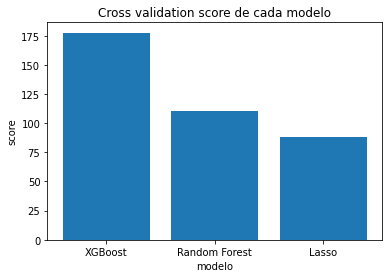

In [51]:
names = list(zip(*results))[0]
values = list(zip(*results))[1]

plt.bar(range(len(results)), values, tick_label=names)
plt.title('Cross validation score de cada modelo')
plt.xlabel('modelo')
plt.ylabel('score')
plt.show()

O modelo **XGBoost** teve a melhor performance.

In [52]:
# get best model
model_flag = None
best_model = results[0][0]
if (best_model == 'XGBoost'):
    model = XGB_model
    model_flag = 0
elif(best_model == 'Lasso'):
    model = Lasso_model
    model_flag = 1
elif(best_model == 'Random Forest'):
    model = RF_model
    model_flag = 2

## Fit

In [53]:
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(alpha=6,
                                            colsample_bytree=0.003617946344623979,
                                            learning_rate=0.999684174831766,
                                            max_depth=5, n_estimators=127,
                                            seed=42, verbosity=0))

## Evaluate

In [54]:
y_pred = model.predict(X_test)

In [55]:
mean_squared_error(y_test, y_pred)

1.929851318493651

# Resultados

O **MSR** do modelo **XGBoost** foi de aproximadamente **1.93**

## Resultados do modelo **XGBoost** - Real vs Previsto

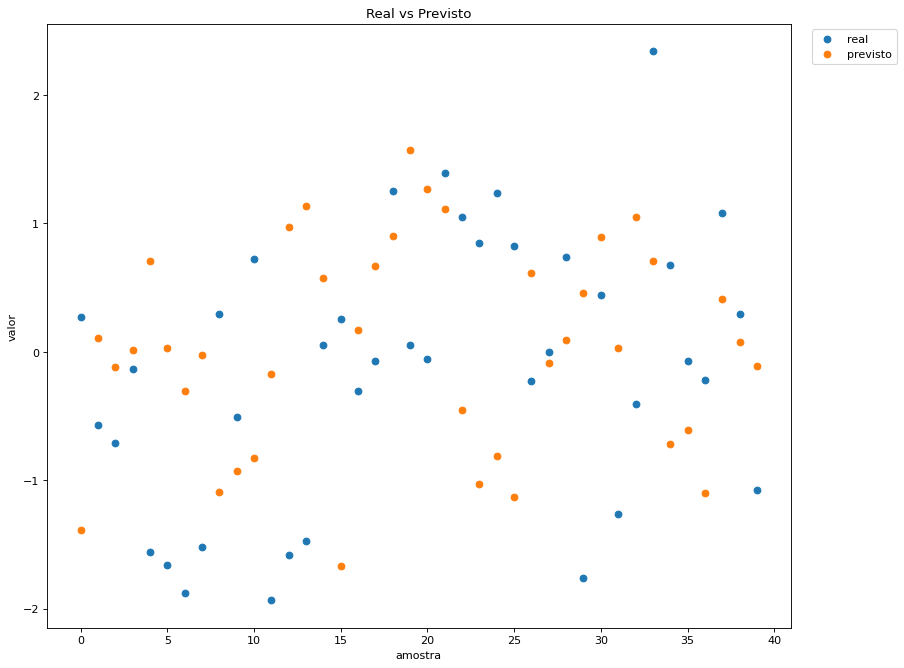

In [56]:
li1 = list(zip(range(1, len(y_test)), y_test))
li2 = list(zip(range(1, len(y_pred)), y_pred))

figure(figsize=(12, 10), dpi=80)
    
plt.ylabel('valor')
plt.xlabel('amostra')

plt.scatter(y=y_test, x=range(0, y_test.size), label='real')
plt.scatter(y=y_pred, x=range(0, y_test.size), label='previsto')

plt.legend(bbox_to_anchor=(1.15, 1), loc="upper right")
plt.title("Real vs Previsto")

plt.show()

## Análise da importância das Features

In [57]:
def get_feature_importances(model):
    day_importance = 0
    month_importance = 0
    year_importance = 0
    vendas_importance = 0

    if model_flag == 0:
      feature_names = model.estimators_[0].get_booster().feature_names
    else:
      feature_names = model.estimators_[0].feature_names_in_
    
    for i in range(len(feature_names)):
        if 'Dia' in feature_names[i]:
            day_importance += (model.estimators_[0].feature_importances_[i] + model.estimators_[1].feature_importances_[i] + model.estimators_[2].feature_importances_[i] + model.estimators_[3].feature_importances_[i] + model.estimators_[4].feature_importances_[i])/5
        elif 'Mes' in feature_names[i]:
            month_importance += (model.estimators_[0].feature_importances_[i] + model.estimators_[1].feature_importances_[i] + model.estimators_[2].feature_importances_[i] + model.estimators_[3].feature_importances_[i] + model.estimators_[4].feature_importances_[i])/5
        elif 'Ano' in feature_names[i]:
            year_importance += (model.estimators_[0].feature_importances_[i] + model.estimators_[1].feature_importances_[i] + model.estimators_[2].feature_importances_[i] + model.estimators_[3].feature_importances_[i] + model.estimators_[4].feature_importances_[i])/5
        elif 'Vendas' in feature_names[i]:
            vendas_importance += (model.estimators_[0].feature_importances_[i] + model.estimators_[1].feature_importances_[i] + model.estimators_[2].feature_importances_[i] + model.estimators_[3].feature_importances_[i] + model.estimators_[4].feature_importances_[i])/5
            
    return {'Vendas':vendas_importance, 'Dia':day_importance
            , 'Mês':month_importance, 'Ano':year_importance}

In [58]:
feature_importances = sorted(get_feature_importances(model).items(), key=lambda x: x[1], reverse=True)

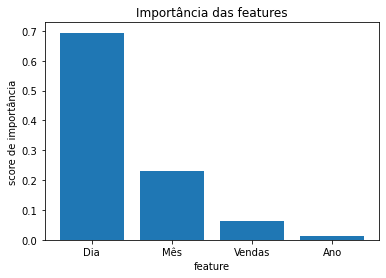

In [59]:
names = list(zip(*feature_importances))[0]
values = list(zip(*feature_importances))[1]

plt.bar(range(len(feature_importances)), values, tick_label=names)
plt.title('Importância das features')
plt.xlabel('feature')
plt.ylabel('score de importância')
plt.show()

Disparadamente a variável mais importante nas previsões do modelo é o **dia**. **Mês** e **vendas** possuem importâncias menores, porém significantes. Já **ano** tem score de importância próximo de zero e portanto não é significante para esse modelo.

# Conclusão

O modelo com melhor performance no dataset foi o **XGBoost**. A falta de amostras e features no dataset certamente está causando **underfitting**, o que dificulta as previsões e a estimativa da performance do modelo. O gráfico "Real vs Previsto" mostra que algumas previsões foram próximas, enquanto em outras amostras as previsões foram mais distantes. Outro ponto perceptível é que o modelo explorou bem o range de valores nas previsões.

*Muito obrigado por vir até o fim :)*